$$\textbf{Machine Learning. Tarea 4: Autocodificador}$$
$$\textit{Y. Sarahi García Gozález}$$

Esta tarea la compile localmente en mi máquina pues en colab no logré hcaerlo (se acababa la ram con los datos). Utilicé 2000 imágenes e hice un aumento de 500 imágenes sobre el conjunto de Train (mi máquina no me permitió hacer más, después de 500 moría el kernel).


<font size=4 color='mediumslateblue'>  

$\textit{Librerías}$

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
import sklearn as sk
import scipy as sp
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import read_depth as rd


In [2]:
print("Tarea realizada en MacOs. \nLas versiones de las librerías y de python utilizadas fueron:\n")
from platform import python_version
print("Python version:", python_version())
print("NumPy version:", np.__version__)
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE") 


Tarea realizada en MacOs. 
Las versiones de las librerías y de python utilizadas fueron:

Python version: 3.11.5
NumPy version: 1.23.5
Tensor Flow Version: 2.16.1
Keras Version: 3.3.3
Scikit-Learn 1.3.0
SciPy 1.11.4
GPU is available


In [3]:
len(tf.config.list_physical_devices('GPU'))

1

<font size=4 color='mediumslateblue'>  

$\textit{Prepocesamiento de los datos}$

Descargué los datos y para cargar los mapas de prfundidad utilicé la libreria read_depht que proporciona la página de donde obtuvimos el dataset

In [4]:
def load_data(datos_phat, input_shape=(224, 224)):
    #listas vacias para almacenar las imagenes y los mapas de profundidad
    images = []
    depth_maps = []
    #creamos un lista con los directorios que se encuentra dentro de la carpeta "datos"
    directorios = os.listdir(datos_phat)
    for directorio in directorios: #iteramos sobre éstos 

        #si dentro de "datos" se encuentra un archivo .DS_Store, lo ignoramos (esto pasa en sistema MacOs)
        if directorio=='.DS_Store':
            continue

        #guardamos ruta de directorio imagenes
        image_directorio = os.path.join(datos_phat, directorio, "image")
        #guardamos ruta de directorio mapas de profundidad
        depth_map_directorio = os.path.join(datos_phat, directorio, "groundtruth_depth")

        #creamos una lista de los archivos dentro del directorio imagenes
        image_files = os.listdir(image_directorio)
        #creamos una lista de los archivos dentro del directorio mapas d profundudad
        depth_map_files = os.listdir(depth_map_directorio)

        #iteramos sobre las listas anteriores 
        for image_file, depth_map_file in zip(image_files, depth_map_files):
            #creamos la ruta completa de la imagen actual
            image_path = os.path.join(image_directorio, image_file)
            #leemos
            image = cv2.imread(image_path)
            #ajutamo la escala
            image = cv2.resize(image, (input_shape[1], input_shape[0]))

            #creamos la ruta completa del mapa actual
            depth_map_path = os.path.join(depth_map_directorio, depth_map_file)
            #leemos
            depth_map = rd.depth_read(depth_map_path)
            depth_map =  cv2.resize(depth_map, (224, 224))

            #agregmos la imagen y el mapa actuales a las listas correspondiente
            images.append(image)
            depth_maps.append(depth_map)

    return np.array(images), np.array(depth_maps)

In [17]:
#cargamos los datos usando la funcion load data
path = "/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/machine/04_Tarea4_machine/datos"
X, y = load_data(path)


Aumentemos el numero de imagenenes en el conjunto  X y y

In [18]:

datagen = ImageDataGenerator(
    rotation_range=20,      #rotación aleatoria en grados
    width_shift_range=0.1,  #esplazamiento horizontal aleatorio
    height_shift_range=0.1, #Desplazamiento vertical aleatorio
    shear_range=0.2,        # Intensidad de la deformación de cizalla
    zoom_range=0.2,         #rango de zoom aleatorio
    horizontal_flip=True,  #Volteo horizontal aleatorio
    fill_mode='nearest'     #Modo de relleno para los píxeles fuera de los límites de la imagen original
)


batch_size = 64
num_augmented_images = 1000  # Número de imágenes a generar
num_batches = num_augmented_images // batch_size
#listas vacias para datos aumentds
X_uaumentado = []
y_uaumentado = []

for batch in range(num_batches):
    #Generamos un lote de imágenes aumentadas y etiquetas correspondientes
    augmented_data = next(datagen.flow(X, y, batch_size=batch_size, shuffle=False))
    #Extraemos las imágenesy las etiquetas 
    X_batch_augmented, y_batch_augmented = augmented_data
    #La agregamos a los conjuntos corresp.
    X_uaumentado.append(X_batch_augmented)
    y_uaumentado.append(y_batch_augmented)

# Convertimos la lista de lotes de imágenes aumentadas en un único conjunto
X_uaumentado = np.concatenate(X_uaumentado, axis=0)
y_uaumentado = np.concatenate(y_uaumentado, axis=0)



Ahora concatenamos las imágenes y mapas aumentados con los conjuntosoriginales

In [19]:
X = np.concatenate([X, X_uaumentado], axis=0)

In [20]:
y = np.concatenate([y, y_uaumentado], axis=0)

Se pide:
* Entrada: imágenes rgb+ en 224x224 pixéles
* Salida: imágenes escala de gris codificando profundidad en 224x224 pixeles

In [21]:
print("Shape of images X:", X.shape)
print("Shape of depth maps y:", y.shape)

Shape of images X: (2960, 224, 224, 3)
Shape of depth maps y: (2960, 224, 224)


In [22]:
X = X.astype('float32') / 255.0
Y = y.astype('float32') / 255.0

Dividimos en entrenamiento 80% y prueba 20%

In [23]:
#Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2368, 224, 224, 3)
Shape of y_train: (2368, 224, 224)
Shape of X_test: (592, 224, 224, 3)
Shape of y_test: (592, 224, 224)


(-0.5, 223.5, 223.5, -0.5)

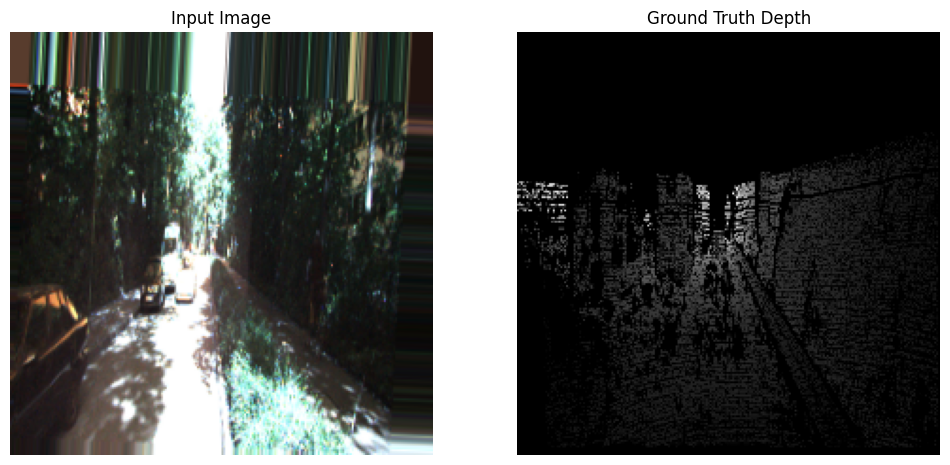

In [27]:
ejem=2300 #ejemplo imagen aumentada
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(X_train[ejem])
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(y_train[ejem], cmap='gray')
plt.title('Ground Truth Depth')
plt.axis('off')

<font size=4 color='mediumslateblue'>  

$\textit{Etapa de codificación: red preentrenada VGG16}$

Los pesos de la red preentreada se descargaron a una carpeta local porque no pude acceder a ellos. 

In [28]:
#ruta de los pesos de vgg16
weights_path = '/Users/ely/Documents/pre-trained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

#Imágenes RGB de 224x224 pixeles para la entrada
img_size = (224, 224, 3)  

#Usanos VGG16 con los pesos descargados, sólo la etapa de extración de resgos, e input de 224x224 RGB
conv_base = VGG16(weights=weights_path, include_top=False, input_shape=img_size)
#pesos no entrenable para que no se actualicen durante el entrenamiento del autoencoder
conv_base.trainable = False
conv_base.summary()


2024-05-01 17:39:49.433570: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-01 17:39:49.434408: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-01 17:39:49.434422: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-01 17:39:49.435004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-01 17:39:49.435666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

La salida final del modelo base cargado (conv_base) tienen la forma (7, 7, 512).

In [29]:
#Espacio latente (<=8)x(<=8)xC
max_latent_dim = 7 * 7 * 256
#Creamos el codificador
codificador = models.Sequential([
    conv_base, # modelo vgg16
],name="codificador")
codificador.build(input_shape= (None, 224, 224, 3) ) #construimos el modelo "codificador"
# Mostrar la arquitectura del codificador
codificador.summary()

Model: "codificador"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

<font size=4 color='mediumslateblue'>  

$\textit{Etapa de decodificación: red preentrenada VGG16}$

Esta fue la red más simple que no me "fundía" la imagen, intente agregar cosas pero mi kernel moría, tamién intenté usar más imágenes aumentadas pero pasaba lo mismo.

In [30]:
decodificador = models.Sequential([
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='sigmoid')
],name="decodificador")

decodificador.build(input_shape=(None, 7, 7, 512)) #construimos el modelo

# Mostrar la arquitectura del decodificador
decodificador.summary()

Model: "decodificador"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (None, 14, 14, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 56, 56, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 112, 112, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 224, 224, 1)    │           513 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,786,273 (10.63 MB)

 Trainable params: 2,786,273 (10.63 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Combinar el codificador y el decodificador
autoencoder = models.Sequential([
    codificador, 
    decodificador  
],name="autoencoder")
autoencoder.build(input_shape=(None, 224, 224, 3))
#arquitectura del autoencoder completo
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ codificador (Sequential)        │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decodificador (Sequential)      │ (None, 224, 224, 1)    │     2,786,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,500,961 (66.76 MB)

 Trainable params: 2,786,273 (10.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [41]:
#Parametros para el modelo autoencoder
num_epochs = 15
lr = 0.0001
batch_size = 64

In [42]:
checkpoint_filepath = 'best_model.keras'
#callback para el mejor modelo 
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#usamos adam
optimizer = Adam(learning_rate=lr)
#compilamos
autoencoder.compile(optimizer=optimizer, loss='mse')
#entrenamos
history = autoencoder.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])


Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 33.1284
Epoch 1: val_loss improved from inf to 32.47179, saving model to best_model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 33.1096 - val_loss: 32.4718
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 32.0832
Epoch 2: val_loss did not improve from 32.47179
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 32.0917 - val_loss: 32.4807
Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 32.5015
Epoch 3: val_loss did not improve from 32.47179
37/37 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - loss: 32.4989 - val_loss: 32.4772
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 31.9089
Epoch 4: val_loss improved from 32.47179 to 32.47096, saving model to best_model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - loss: 31.9218 - val_loss: 32.4710
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 32.4177
Epoch 5: val_loss improved from 32.47096 to 32.47095, saving model to best_model.keras
37/37 ━━━━━━━━━━━━━━━━

In [43]:
#predicción
y_pred= autoencoder.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 639ms/step


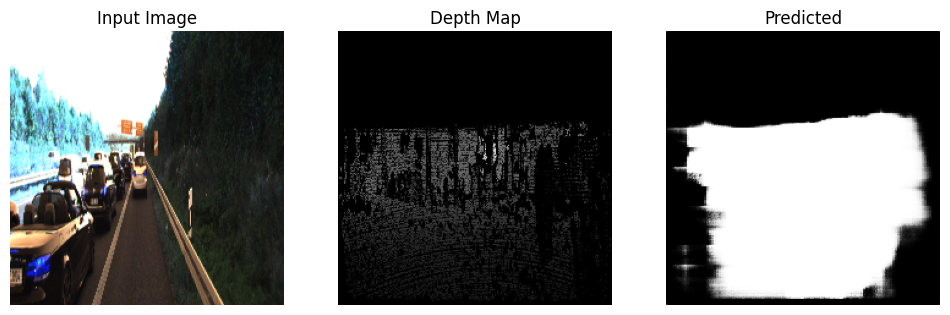

In [54]:
ejem2=142

plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(X_test[ejem2])
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_test[ejem2], cmap='gray')
plt.title('Depth Map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_pred[ejem2], cmap='gray')
plt.title('Predicted')
plt.axis('off')

plt.show()

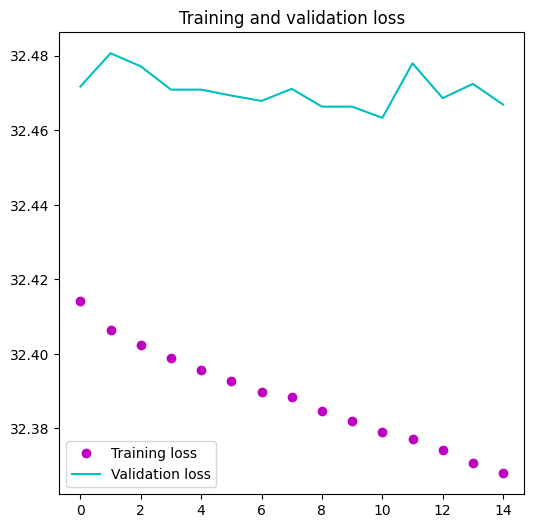

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(6,6))


plt.plot(epochs, loss, 'mo', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<font size=4 color='mediumslateblue'>  

$\textit{Ajuste completo}$

Ahora entrenamos usando todos los parámetros

In [47]:
conv_base.trainable = True
# Combinar el codificador y el decodificador
autoencoder_completo = models.Sequential([
    codificador, 
    decodificador  
],name="autoencoder")
autoencoder.build(input_shape=(None, 224, 224, 3))
#arquitectura del autoencoder completo
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ codificador (Sequential)        │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decodificador (Sequential)      │ (None, 224, 224, 1)    │     2,786,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,073,509 (88.02 MB)

 Trainable params: 17,500,961 (66.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,572,548 (21.26 MB)

In [48]:
#Parametros para el modelo autoencoder
num_epochs = 10
lr = 0.0001
batch_size = 32

In [50]:
checkpoint_filepath = 'best_model1.keras'
#callback para el mejor modelo 
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#usamos adam
optimizer = Adam(learning_rate=lr)
#compilamos
autoencoder_completo.compile(optimizer=optimizer, loss='mse')
#entrenamos
history = autoencoder_completo.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 32.7934
Epoch 1: val_loss improved from inf to 32.50518, saving model to best_model1.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - loss: 32.7903 - val_loss: 32.5052
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 33.1810
Epoch 2: val_loss improved from 32.50518 to 32.49282, saving model to best_model1.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 342s 5s/step - loss: 33.1719 - val_loss: 32.4928
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 32.3876
Epoch 3: val_loss improved from 32.49282 to 32.48704, saving model to best_model1.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 387s 5s/step - loss: 32.3889 - val_loss: 32.4870
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 32.2483
Epoch 4: val_loss improved from 32.48704 to 32.48471, saving model to best_model1.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 443s 6s/step - loss: 32.2514 - val_loss: 32.4847
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 31.9821
Epoch 5: val_loss improv

In [51]:
y_pred_completo= autoencoder.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 682ms/step


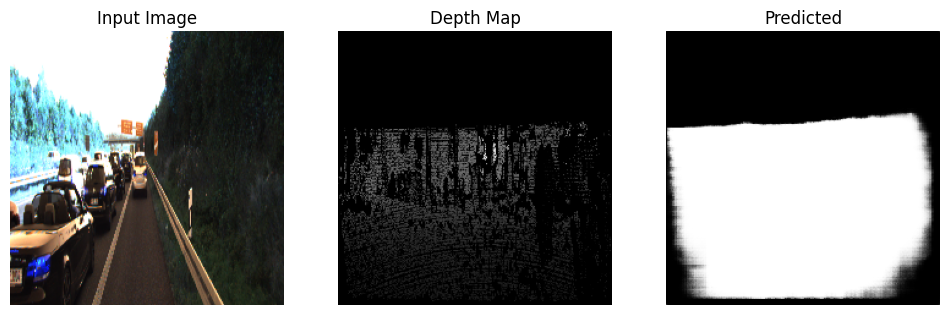

In [55]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(X_test[ejem2])
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_test[ejem2], cmap='gray')
plt.title('Depth Map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_pred_completo[ejem2], cmap='gray')
plt.title('Predicted')
plt.axis('off')

plt.show()

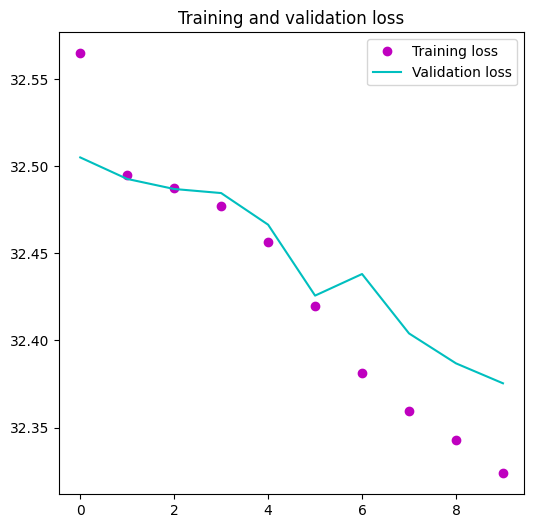

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(6,6))


plt.plot(epochs, loss, 'mo', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Creo que la quizá la arquitectura del decoder es muy simple además de que sólo usé dos mil imágenes (más mil aumentadas) y por eso no obteve mejores resultados, traté también cambiando los hiperparámetros pero la mejora, si hay, es imperceptiple.